# 02-01 : Identify Good Students

Can solve a sub problem of identifying good students based on their activities in a level group.

In [87]:
import sys
import gc
import logging

from typing import Iterable
from typing import Tuple

import pandas as pd
import numpy as np

import keras
from keras import optimizers
from keras.models import Sequential, Model

from keras.layers import Conv2D, Dense, Dropout, Flatten, LeakyReLU, \
                          LSTM, MaxPooling2D, concatenate, Reshape

from keras.layers import Input
from keras import callbacks
from keras import regularizers

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Configure Logging

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.FileHandler("ex05_06.log"),
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-12 10:16:15 INFO     Started


## Load Source Data

In [4]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

In [6]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [7]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [8]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

## Data Preprocessing

In [9]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [10]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


## Explore Student Scores

In [11]:
df_scores = df_source_labels \
    .groupby(['session_id', 'level_group']) \
    .agg({'correct': ['sum', 'count']}) \
    .droplevel(0, axis=1) \
    .reset_index() \
    .query(('(level_group == "0-4" and count == 3) or'
            '(level_group == "5-12" and count == 10) or'
            '(level_group == "13-22" and count == 5)')) \
    .assign(score=lambda df: df['sum'] / df['count'])

display(df_scores.head(6))

,session_id,level_group,sum,count,score
0,20090312431273200,0-4,3,3,1.000000
1,20090312431273200,13-22,4,5,0.800000
2,20090312431273200,5-12,9,10,0.900000
3,20090312433251036,0-4,2,3,0.666667
4,20090312433251036,13-22,3,5,0.600000
5,20090312433251036,5-12,5,10,0.500000


level_group
0-4      Axes(0.125,0.11;0.775x0.77)
13-22    Axes(0.125,0.11;0.775x0.77)
5-12     Axes(0.125,0.11;0.775x0.77)
dtype: object

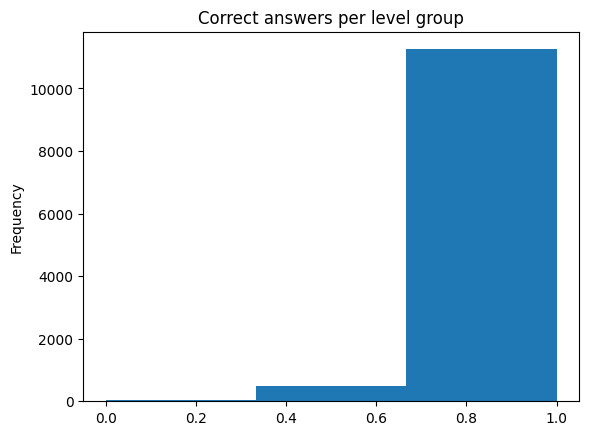

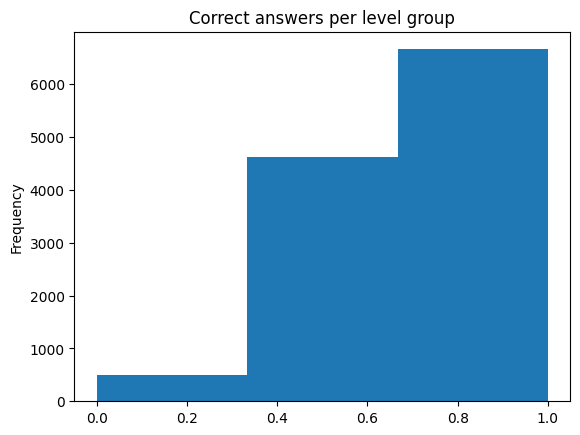

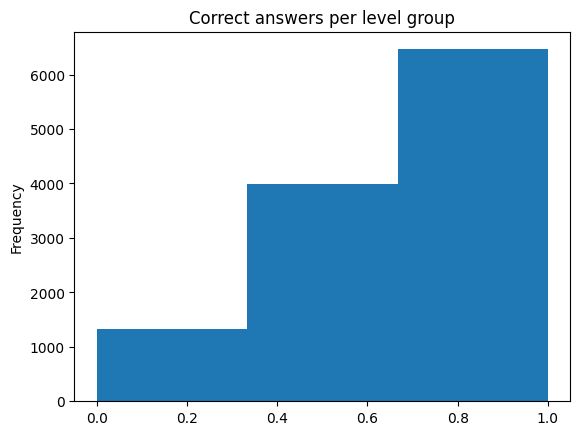

In [12]:
df_scores \
    .groupby('level_group') \
    .plot(kind='hist', y='score', bins=3, legend=False, title='Correct answers per level group')
    

### Add Symbolic Score

In [13]:
df_scores['symbolic_score'] = df_scores['score'].apply(lambda x: 'A' if x >= 0.9 else 'B' if x >= 0.6 else 'C')

display(df_scores.head(6))

display(
    df_scores \
        .groupby(['level_group', 'symbolic_score']) \
        .count()
)

,session_id,level_group,sum,count,score,symbolic_score
0,20090312431273200,0-4,3,3,1.000000,A
1,20090312431273200,13-22,4,5,0.800000,B
2,20090312431273200,5-12,9,10,0.900000,A
3,20090312433251036,0-4,2,3,0.666667,B
4,20090312433251036,13-22,3,5,0.600000,B
5,20090312433251036,5-12,5,10,0.500000,C


session_id   sum  count  score
level_group symbolic_score                                
0-4         A                     8045  8045   8045   8045
            B                     3206  3206   3206   3206
            C                      528   528    528    528
13-22       A                     2460  2460   2460   2460
            B                     7464  7464   7464   7464
            C                     1855  1855   1855   1855
5-12        A                     2208  2208   2208   2208
            B                     6046  6046   6046   6046
            C                     3525  3525   3525   3525

In [14]:
symbolic_score_feature = pd.get_dummies(df_scores['symbolic_score']).to_numpy()
df_scores['symbolic_score_feature'] = pd.Series(symbolic_score_feature.tolist())
df_scores

,session_id,level_group,sum,count,score,symbolic_score,symbolic_score_feature
0,20090312431273200,0-4,3,3,1.000000,A,"[1, 0, 0]"
1,20090312431273200,13-22,4,5,0.800000,B,"[0, 1, 0]"
2,20090312431273200,5-12,9,10,0.900000,A,"[1, 0, 0]"
3,20090312433251036,0-4,2,3,0.666667,B,"[0, 1, 0]"
4,20090312433251036,13-22,3,5,0.600000,B,"[0, 1, 0]"
...,...,...,...,...,...,...,...
35332,22100219442786200,13-22,4,5,0.800000,B,"[0, 1, 0]"
35333,22100219442786200,5-12,7,10,0.700000,B,"[0, 1, 0]"
35334,22100221145014656,0-4,1,3,0.333333,C,"[0, 0, 1]"
35335,22100221145014656,13-22,2,5,0.400000,C,"[0, 0, 1]"


## Functions to Create Features

In [15]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which features will be added.
    """
    return df_source_labels \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \

# test the function
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


### Symbolic Score Feature

In [16]:
def add_symbolic_score_feature(features:pd.DataFrame,
                               X:pd.DataFrame,
                               y:pd.DataFrame) -> None:
    """
    Adds the symbolic score feature to the features dataset.
    """
    # get the symbolic scores
    df_scores = y \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['sum', 'count']}) \
        .droplevel(0, axis=1) \
        .reset_index() \
        .assign(score=lambda df: df['sum'] / df['count']) \
        .assign(symbolic_score=lambda df: df['score'].apply(lambda x: 'A' if x >= 0.9 else 'B' if x >= 0.6 else 'C')) \
        .sort_values(['session_id', 'level_group'])

    # generate the feature
    symbolic_score_feature = pd.get_dummies(df_scores['symbolic_score']).to_numpy()

    # add the feature to the features dataset
    features['symbolic_score_feature'] = pd.Series(symbolic_score_feature.tolist())    

# test the function
add_symbolic_score_feature(df_features, df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,symbolic_score_feature
0,20090312431273200,0-4,"[1, 0, 0]"
1,20090312431273200,13-22,"[0, 1, 0]"
2,20090312431273200,5-12,"[1, 0, 0]"
3,20090312433251036,0-4,"[0, 1, 0]"
4,20090312433251036,13-22,"[0, 1, 0]"
5,20090312433251036,5-12,"[0, 0, 1]"


### Elapsed Time Feature

<Axes: title={'center': 'Elapsed time distribution'}, ylabel='Frequency'>

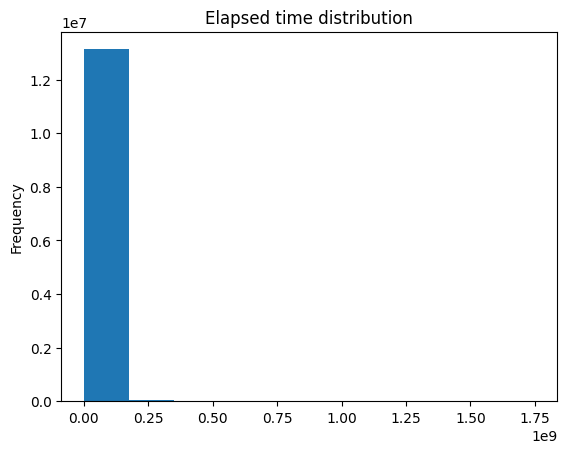

In [17]:
df_source['elapsed_time'].plot(kind='hist', title='Elapsed time distribution')

In [18]:
print('Min Elapsed Time  :', df_source['elapsed_time'].min())
print('Max Elapsed Time  :', df_source['elapsed_time'].max())
print('Mean Elapsed Time :', df_source['elapsed_time'].mean())

print("50th Percentile   :", df_source['elapsed_time'].quantile(0.5))
print("75th Percentile   :", df_source['elapsed_time'].quantile(0.75))
print("80th Percentile   :", df_source['elapsed_time'].quantile(0.8))
print("90th Percentile   :", df_source['elapsed_time'].quantile(0.9))
print("95th Percentile   :", df_source['elapsed_time'].quantile(0.95))

df_source['elapsed_time'].describe()

Min Elapsed Time  : 0
Max Elapsed Time  : 1749293395
Mean Elapsed Time : 3846890.447290591
50th Percentile   : 1013440.0
75th Percentile   : 1740059.0
80th Percentile   : 1970019.0
90th Percentile   : 2901311.5999999996
95th Percentile   : 5155144.599999998


count    1.317344e+07
mean     3.846890e+06
std      2.701416e+07
min      0.000000e+00
25%      4.394340e+05
50%      1.013440e+06
75%      1.740059e+06
max      1.749293e+09
Name: elapsed_time, dtype: float64

In [19]:
def add_elapsed_time_feature(features:pd.DataFrame,
                               X:pd.DataFrame,
                               y:pd.DataFrame,
                               max_elapsed_time:int = 3e6) -> None:
    """
    Add the maximum elapsed time feature to the features dataset.
    """
    # get the symbolic scores
    df_elapsed_time = X \
        .groupby(['session_id', 'level_group']) \
        .agg({'elapsed_time': 'max'}) \
        .reset_index()
    
    df_elapsed_time = df_features.set_index(['session_id', 'level_group']) \
        .join(df_elapsed_time.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    elapsed_time_feature = np.clip(df_elapsed_time['elapsed_time'], 0, max_elapsed_time)
    elapsed_time_feature = elapsed_time_feature / max_elapsed_time
    
    # add the feature to the features dataset
    features['elapsed_time'] = elapsed_time_feature

# test the function
#df_features.drop(columns=['elapsed_time'], inplace=True)
add_elapsed_time_feature(df_features, df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,symbolic_score_feature,elapsed_time
0,20090312431273200,0-4,"[1, 0, 0]",0.064953
1,20090312431273200,13-22,"[0, 1, 0]",0.424226
2,20090312431273200,5-12,"[1, 0, 0]",0.166412
3,20090312433251036,0-4,"[0, 1, 0]",0.077917
4,20090312433251036,13-22,"[0, 1, 0]",1.000000
5,20090312433251036,5-12,"[0, 0, 1]",0.272536


### Screen Heatmap Feature

uint8
[[0 0 0 0 0]
 [0 0 5 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [4 4 0 0 0]]


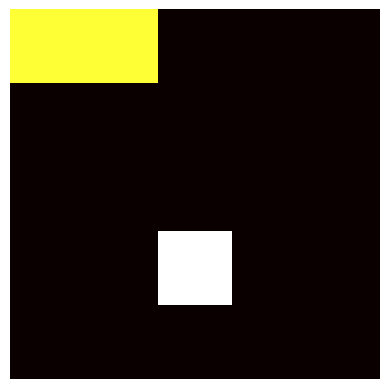

In [20]:
def create_level_screen_heatmap(df_session:pd.DataFrame,
                          level:int,
                          bins:int=50,
                          min_value:int=0,
                          max_value:int=376) -> np.ndarray:
    """
    Creates a heatmap for the screen of the given level.
    """
    df_level = df_session \
        .query('level == @level') \
        .fillna(0)
    
    # return an empty heatmap if there are no events for the given level
    if df_level.shape[0] == 0:
        return np.zeros((bins, bins), dtype=np.uint8)

    # Create the 2D histogram
    heatmap, xedges, yedges = np.histogram2d(df_level.screen_coor_y, 
                                             df_level.screen_coor_x, 
                                             bins=bins)
    
    # Normalize the heatmap
    normalized_heatmap = (heatmap - min_value) / (max_value - min_value)

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap

# test the function
session_id = 20090312433251036
heatmap = create_level_screen_heatmap(df_source.query('session_id == @session_id'), 0, bins=5)
print(heatmap.dtype)
print(heatmap)

plt.imshow(heatmap, cmap='hot', origin='lower')
plt.axis('off')
plt.show()

#### Find The Maximum Value In The Heatmap

In [21]:
def get_heatmap_max_min(df_source:pd.DataFrame, 
                        df_source_labels:pd.DataFrame) -> Tuple[float, float]:
    """
    Returns the maximum and minimum values of the heatmap to use
    for normalization.
    """
    best_max = None
    best_min = None

    for session_id in tqdm(df_source_labels['session_id'].unique()):
        df_session = df_source.query('session_id == @session_id')
        for level in range(1, 23):
            heatmap = create_level_screen_heatmap(df_session, level)
            
            cur_max = np.max(heatmap)
            cur_min = np.min(heatmap)
            
            if best_max is None or cur_max > best_max:
                best_max = cur_max

            if best_min is None or cur_min < best_min:
                best_min = cur_min

    print(f'Best max: {best_max}')
    print(f'Best min: {best_min}')

    return best_max, best_min

# get the max and min values
#best_max, best_min = get_heatmap_max_min(df_source, df_source_labels)
        

In [22]:
def create_level_group_screen_heatmap(df_session:pd.DataFrame,
                                      level_group:str,
                                      bins:int=50,
                                      min_value:int=0,
                                      max_value:int=376) -> np.ndarray:
    """
    Creates heatmaps for the screen of the given level group.
    """
    heatmaps = []
    level_range = range(0, 23)

    # select only the levels in the given level group
    df_level_group = df_session.query('level_group == @level_group')
    #print(df_level_group.shape)

    # create the heatmaps
    for level in level_range:
        heatmap = create_level_screen_heatmap(df_level_group, level, bins, min_value, max_value)

        # normalize the heatmap
        heatmap = heatmap / 255

        heatmaps.append(heatmap)

    return np.array(heatmaps, dtype=np.float32)

# test the function
session_id = 20090312433251036
level_group = '0-4'
#level_group = '5-12'
#level_group = '13-22'
df_session = df_source.query('session_id == @session_id')

group_heatmaps = create_level_group_screen_heatmap(df_session, level_group, bins=5)
print(group_heatmaps.shape)
#display(group_heatmaps)


(23, 5, 5)


In [23]:
def add_screen_heatmap_feature(features:pd.DataFrame,
                               X:pd.DataFrame,
                               y:pd.DataFrame,
                               bins:int=50,
                               min_value:int=0,
                               max_value:int=376) -> None:
    """
    Adds the screen heatmap feature to the features dataset.
    """
    heatmaps_feature = []
    for session_id in tqdm(features['session_id'].unique()):
        df_session = X.query('session_id == @session_id')
        df_session_features = features.query('session_id == @session_id')

        # process each level group the session features
        for index, row in df_session_features.iterrows():
            level_group = row['level_group']

            group_heatmaps = create_level_group_screen_heatmap(df_session, level_group, bins, min_value, max_value)
            heatmaps_feature.append(group_heatmaps)

    # add the feature to the features dataset
    features['screen_heatmap_feature'] = pd.Series(heatmaps_feature)

# test the function
add_screen_heatmap_feature(df_features, df_source, df_source_labels, bins=5)

with pd.option_context('display.max_columns', None):
    display(df_features.head(10))

  0%|          | 0/11779 [00:00<?, ?it/s]

,session_id,level_group,symbolic_score_feature,elapsed_time,screen_heatmap_feature
0,20090312431273200,0-4,"[1, 0, 0]",0.064953,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
1,20090312431273200,13-22,"[0, 1, 0]",0.424226,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,20090312431273200,5-12,"[1, 0, 0]",0.166412,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,20090312433251036,0-4,"[0, 1, 0]",0.077917,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0196..."
4,20090312433251036,13-22,"[0, 1, 0]",1.000000,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
5,20090312433251036,5-12,"[0, 0, 1]",0.272536,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
6,20090314121766812,0-4,"[1, 0, 0]",0.131120,"[[[0.0, 0.0, 0.0, 0.0, 0.003921569], [0.0, 0.0..."
7,20090314121766812,13-22,"[0, 1, 0]",0.711261,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
8,20090314121766812,5-12,"[0, 0, 1]",0.339017,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
9,20090314363702160,0-4,"[1, 0, 0]",0.072525,"[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."


## Functions to Create Datasets

In [24]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.4)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [25]:
def create_feature_dataset(df_features:pd.DataFrame,
                           df_source_labels:pd.DataFrame,
                           session_list: list,
                           level_group:str,
                           feature_list:list) -> np.array:
    # get the features and labels for the given level group
    df_features_level_group = df_features.query('level_group == @level_group and session_id in @session_list')
    df_labels_level_group = df_source_labels.query('level_group == @level_group and session_id in @session_list')

    feature_dataset = []

    # get the features for each row in the level group labels dataset
    current_session_id = None
    df_session_features = None

    for index, row in tqdm(df_labels_level_group.iterrows()):        
        session_id = row['session_id']

        # get the features for the session
        if session_id != current_session_id:
            current_session_id = session_id
            df_session_features = df_features_level_group.query('session_id == @session_id')

        # check if the session has features
        if df_session_features.shape[0] == 0:
            raise Exception(f'No features for session {session_id}!')
                            
        # get the features for the row
        row_features = []
        for feature in feature_list:
            feature_value = df_session_features[feature].values[0]

            # check if the feature value is iterable
            if isinstance(feature_value, Iterable):
                row_features.extend(feature_value)
            else:
                row_features.append(feature_value)

        # add the row features to the output dataset
        feature_dataset.append(row_features)

    return np.array(feature_dataset)

# test the function
session_list = df_source_labels['session_id'].unique()[:3]
level_group = '0-4'
#feature_list = ['symbolic_score_feature', 'symbolic_score_feature']
#feature_list = ['screen_heatmap_feature']
feature_list = ['elapsed_time']
#feature_list = ['elapsed_time', 'symbolic_score_feature']

features = create_feature_dataset(df_features, df_source_labels, session_list, level_group, feature_list)
print(features)
print(features.shape)

0it [00:00, ?it/s]

[[0.06495333]
 [0.07791733]
 [0.13112   ]
 [0.06495333]
 [0.07791733]
 [0.13112   ]
 [0.06495333]
 [0.07791733]
 [0.13112   ]]
(9, 1)


### Create Answers Dataset

In [26]:
def create_answers_dataset(session_list: list,
                           df_source_labels:pd.DataFrame) -> np.array:
    # get the relevant sessions
    answers = df_source_labels \
        .query('session_id in @session_list') \
        .sort_values(by=['session_id', 'question_num']) \
        .correct \
        .values
    
    return np.array(answers, dtype=np.int8)


# test the function
session_list = df_source_labels['session_id'].unique()[:3]
test_answers = create_answers_dataset(session_list, df_source_labels)
test_answers

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int8)

In [67]:
def create_answers_feature_dataset(session_list:list,
                                   df_source_labels:pd.DataFrame,
                                   df_features:pd.DataFrame,
                                   feature_list:list,
                                   include_question:bool=True) -> np.array:
    answers = df_source_labels \
        .query('session_id in @session_list') \
        .sort_values(by=['session_id', 'question_num'])
    
    
    feature_dataset = []
    for index, row in tqdm(answers.iterrows()):
        session_id = int(row['session_id'])
        question_num = int(row['question_num'])
        level_group = row['level_group']

        # get the features for the session
        df_session_features = df_features.query('session_id == @session_id and level_group == @level_group')
        
        # check if the session has features
        if df_session_features.shape[0] == 0:
            raise Exception(f'No features for session {session_id}!')
        
        # get the features for the row
        row_features = []

        # get the question number one-hot encoded
        if include_question:
            question_num_one_hot = np.zeros(18, dtype=np.int8)
            question_num_one_hot[question_num-1] = 1
            row_features.extend(question_num_one_hot)
        
        for feature in feature_list:
            feature_value = df_session_features[feature].values[0]

            # check if the feature value is iterable
            if isinstance(feature_value, Iterable):
                row_features.extend(feature_value)
            else:
                row_features.append(feature_value)

        # add the row features to the output dataset
        feature_dataset.append(row_features)

    return np.array(feature_dataset)
    
# test the function
session_list = df_source_labels['session_id'].unique()[:1]
feature_list = ['elapsed_time']
#feature_list = []
test_features = create_answers_feature_dataset(session_list, df_source_labels, df_features, feature_list, include_question=True)
test_features

0it [00:00, ?it/s]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06495333],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06495333],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06495333],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.   

## Functions for Model Training

In [28]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [29]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [30]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray,
        show_plots: bool = True) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    if show_plots:
        plot_loss(history)
        plot_accuracy(history)

    y_test_score = model.predict(X_test)
    #threshold, _, _ = optimize_f1(y_test, y_test_score)
    threshold = 0.5

    report = classification_report(y_test, y_test_score > threshold, zero_division=1)
    print(report)
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold, report

In [31]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [160]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [159]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        clear_learning: bool = False,
        show_plots: bool = True) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    # clear the learning output if required
    if clear_learning:
        clear_output()

    return test_model(model, history, X_test, y_test, show_plots=show_plots)

## Data Selection

In [34]:
random_state = 51
sample_size = df_source_labels['session_id'].nunique()
#sample_size = 5000

In [35]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state)

Train: 7067
Validation: 2356
Test: 2356


In [36]:
df_complete_sessions = df_source_labels \
    .groupby(['session_id', 'level_group']) \
    .agg({'correct': ['sum', 'count']}) \
    .droplevel(0, axis=1) \
    .reset_index() \
    .query(('(level_group == "0-4" and count == 3) or'
            '(level_group == "5-12" and count == 10) or'
            '(level_group == "13-22" and count == 5)')) \
    .assign(score=lambda df: df['sum'] / df['count'])

print(f'Total Number of sessions    : {df_source_labels.session_id.nunique()}')
print(f'Number of complete sessions : {df_complete_sessions.session_id.nunique()}')
#display(df_complete_sessions.head(6))

Total Number of sessions    : 11779
Number of complete sessions : 11779


## Predict Good Students

In [37]:
def create_feature_datasets(feature_list:list):
    # create datasets for each level group
    feature_datasets = {}
    for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
        feature_datasets[name] = {}
        
        for level_group in ['0-4', '5-12', '13-22']:
            print(f'Creating {name} dataset for level group {level_group}...')

            feature_datasets[name][level_group] = create_feature_dataset(
                df_features=df_features,
                df_source_labels=df_source_labels,
                session_list=session_list,
                level_group=level_group,
                feature_list=feature_list)
            
    return feature_datasets

### Create Datasets

In [38]:
good_student_features = create_feature_datasets(['screen_heatmap_feature'])

Creating train dataset for level group 0-4...


0it [00:00, ?it/s]

Creating train dataset for level group 5-12...


0it [00:00, ?it/s]

Creating train dataset for level group 13-22...


0it [00:00, ?it/s]

Creating val dataset for level group 0-4...


0it [00:00, ?it/s]

Creating val dataset for level group 5-12...


0it [00:00, ?it/s]

Creating val dataset for level group 13-22...


0it [00:00, ?it/s]

Creating test dataset for level group 0-4...


0it [00:00, ?it/s]

Creating test dataset for level group 5-12...


0it [00:00, ?it/s]

Creating test dataset for level group 13-22...


0it [00:00, ?it/s]

In [39]:
good_student_target = create_feature_datasets(['symbolic_score_feature'])

Creating train dataset for level group 0-4...


0it [00:00, ?it/s]

Creating train dataset for level group 5-12...


0it [00:00, ?it/s]

Creating train dataset for level group 13-22...


0it [00:00, ?it/s]

Creating val dataset for level group 0-4...


0it [00:00, ?it/s]

Creating val dataset for level group 5-12...


0it [00:00, ?it/s]

Creating val dataset for level group 13-22...


0it [00:00, ?it/s]

Creating test dataset for level group 0-4...


0it [00:00, ?it/s]

Creating test dataset for level group 5-12...


0it [00:00, ?it/s]

Creating test dataset for level group 13-22...


0it [00:00, ?it/s]

In [40]:
good_student_elapsed_time = create_feature_datasets(['elapsed_time'])

Creating train dataset for level group 0-4...


0it [00:00, ?it/s]

Creating train dataset for level group 5-12...


0it [00:00, ?it/s]

Creating train dataset for level group 13-22...


0it [00:00, ?it/s]

Creating val dataset for level group 0-4...


0it [00:00, ?it/s]

Creating val dataset for level group 5-12...


0it [00:00, ?it/s]

Creating val dataset for level group 13-22...


0it [00:00, ?it/s]

Creating test dataset for level group 0-4...


0it [00:00, ?it/s]

Creating test dataset for level group 5-12...


0it [00:00, ?it/s]

Creating test dataset for level group 13-22...


0it [00:00, ?it/s]

### Create Model

In [41]:
#level_group = '0-4'
level_group = '5-12'
#level_group ='13-22'


In [42]:
# def get_lstm_model(input_shape: tuple, output_shape:int) -> keras.models:
#     model = Sequential()

#     # Add a Convolutional Neural Network (CNN)
#     model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#     # model.add(Flatten())

#     model.add(Reshape((32, -1))) # reshape the output of the Flatten layer to (batch_size, time_steps, input_dim)
#     model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))    

#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.25))

#     # Add a dense layer for output
#     model.add(Dense(output_shape, activation='sigmoid'))
    
#     return model

# # define the input shape
# input_data = good_student_features['train'][level_group]
# input_shape = (input_data.shape[1], input_data.shape[2], input_data.shape[3])

# # define the output shape
# output_data = good_student_target['train'][level_group]
# output_shape = output_data.shape[1]

# # get the model
# model = get_lstm_model(input_shape=input_shape, output_shape=output_shape)
# print(model.summary())

In [43]:
# def get_flat_model(input_shape: tuple, output_shape:int) -> keras.models:
#     model = Sequential()
#     model.add(Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.4))
#     model.add(Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    
 

#     # Add a dense layer for output
#     model.add(Dense(output_shape, activation='sigmoid'))
    
#     return model

# # get the model
# #model = get_flat_model(input_shape=input_shape, output_shape=output_shape)
# #print(model.summary())

In [44]:
def get_model(input_shape: tuple, output_shape:int) -> keras.models:
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.25))

    # Add a dense layer for output
    model.add(Dense(output_shape, activation='sigmoid'))
    
    return model

# define the input shape
input_data = good_student_features['train'][level_group]
input_shape = (input_data.shape[1], input_data.shape[2], input_data.shape[3])

# define the output shape
output_data = good_student_target['train'][level_group]
output_shape = output_data.shape[1]

# get the model
model = get_model(input_shape=input_shape, output_shape=output_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 575)               0         
                                                                 
 dense (Dense)               (None, 32)                18432     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

2023-03-12 10:39:11.071670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 10:39:11.073957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 10:39:11.074104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 10:39:11.074447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/40
23/36 [==================>...........] - ETA: 0s - loss: 0.7246 - accuracy: 0.3970 

2023-03-12 10:39:12.496113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


36/36 [==============================] - 1s 7ms/step - loss: 0.7020 - accuracy: 0.4118 - val_loss: 0.6244 - val_accuracy: 0.5140
Epoch 2/40
36/36 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.4919 - val_loss: 0.5909 - val_accuracy: 0.5140
Epoch 3/40
36/36 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.5064 - val_loss: 0.5863 - val_accuracy: 0.5140
Epoch 4/40
36/36 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.5141 - val_loss: 0.5783 - val_accuracy: 0.5157
Epoch 5/40
36/36 [==============================] - 0s 3ms/step - loss: 0.5824 - accuracy: 0.5309 - val_loss: 0.5657 - val_accuracy: 0.5424
Epoch 6/40
36/36 [==============================] - 0s 3ms/step - loss: 0.5698 - accuracy: 0.5510 - val_loss: 0.5564 - val_accuracy: 0.5573
Epoch 7/40
36/36 [==============================] - 0s 3ms/step - loss: 0.5624 - accuracy: 0.5590 - val_loss: 0.5531 - val_accuracy: 0.5581
Epoch 8/40
36/36 [=============

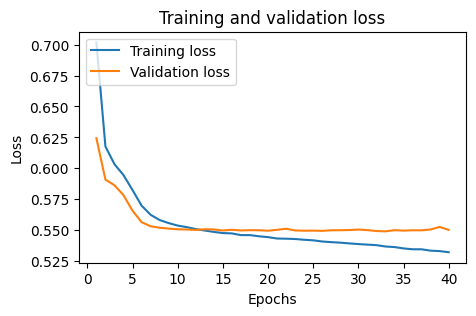

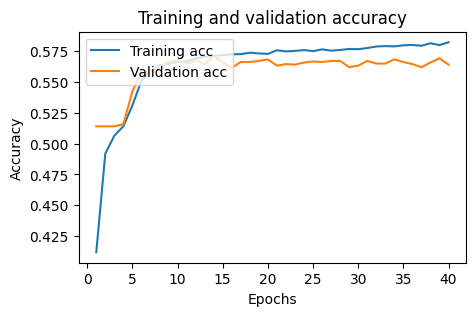

737/737 [==============================] - 0s 562us/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4350
           1       0.56      0.75      0.64     12090
           2       0.59      0.43      0.50      7120

   micro avg       0.57      0.52      0.54     23560
   macro avg       0.72      0.39      0.38     23560
weighted avg       0.65      0.52      0.48     23560
 samples avg       0.61      0.52      0.52     23560

Optimized threshold for best F1: 0.50


In [45]:
_, _ = train_and_test_model(
    model=model,
    X_train=good_student_features['train'][level_group],
    y_train=good_student_target['train'][level_group],
    X_val=good_student_features['val'][level_group],
    y_val=good_student_target['val'][level_group],
    X_test=good_student_features['test'][level_group],
    y_test=good_student_target['test'][level_group],
    epochs=40,
    batch_size=2000,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

## Elapsed Time

In [46]:
# define the input shape
input_data = good_student_elapsed_time['train'][level_group]
input_shape = (input_data.shape[1])
print('input_shape:', input_shape)

# define the output shape
output_data = good_student_target['train'][level_group]
output_shape = output_data.shape[1]
print('output_shape', output_shape)

input_shape: 1
output_shape 3


In [47]:
model = Sequential()
model.add(Dense(32, input_shape=(input_shape,), activation='relu'))
model.add(Dense(64, activation='sigmoid'))

# Add a dense layer for output
model.add(Dense(output_shape, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                64        
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
142/142 [==============================] - 1s 2ms/step - loss: 0.7307 - accuracy: 0.1895 - val_loss: 0.6903 - val_accuracy: 0.2008
Epoch 2/10
142/142 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.4217 - val_loss: 0.6347 - val_accuracy: 0.5140
Epoch 3/10
142/142 [==============================] - 0s 2ms/step - loss: 0.6171 - accuracy: 0.5131 - val_loss: 0.6036 - val_accuracy: 0.5140
Epoch 4/10
142/142 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.5131 - val_loss: 0.5935 - val_accuracy: 0.5140
Epoch 5/10
142/142 [==============================] - 0s 2ms/step - loss: 0.5942 - accuracy: 0.5131 - val_loss: 0.5929 - val_accuracy: 0.5140
Epoch 6/10
142/142 [==============================] - 0s 2ms/step - loss: 0.5938 - accuracy: 0.5131 - val_loss: 0.5926 - val_accuracy: 0.5140
Epoch 7/10
142/142 [==============================] - 0s 2ms/step - loss: 0.5936 - accuracy: 0.5131 - val_loss: 0.5923 - val_accuracy: 0.5140
Epoch 

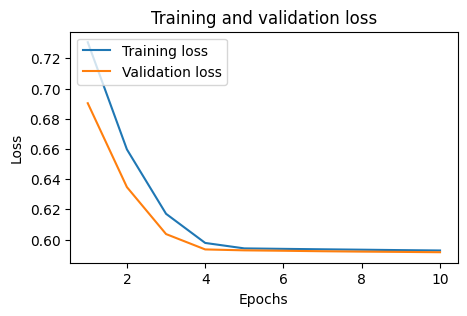

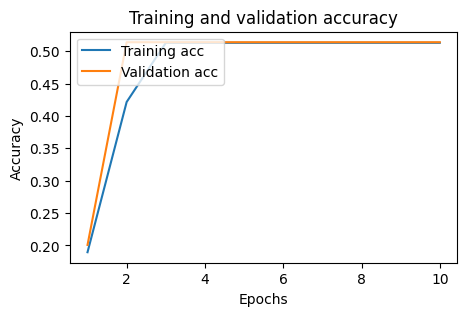

737/737 [==============================] - 0s 487us/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4350
           1       0.52      0.94      0.67     12090
           2       1.00      0.00      0.00      7120

   micro avg       0.52      0.48      0.50     23560
   macro avg       0.84      0.31      0.22     23560
weighted avg       0.75      0.48      0.34     23560
 samples avg       0.55      0.48      0.48     23560

Optimized threshold for best F1: 0.50


In [48]:
_, _ = train_and_test_model(
    model=model,
    X_train=good_student_elapsed_time['train'][level_group],
    y_train=good_student_target['train'][level_group],
    X_val=good_student_elapsed_time['val'][level_group],
    y_val=good_student_target['val'][level_group],
    X_test=good_student_elapsed_time['test'][level_group],
    y_test=good_student_target['test'][level_group],
    epochs=10,
    batch_size=500,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### Merged Model

In [75]:
# elapsed time input and output shapes
elapsed_input_data = good_student_elapsed_time['train'][level_group]
elapsed_input_shape = (elapsed_input_data.shape[1])
print('elapsed_input_shape', elapsed_input_shape)
#print('elapsed_input_data:', elapsed_input_data)

elapsed_output_data = good_student_target['train'][level_group]
elapsed_output_shape = elapsed_output_data.shape[1]
print('elapsed_output_shape', elapsed_output_shape)

elapsed_input_shape 1
elapsed_output_shape 3


In [74]:
# screen heatmap input and output shapes
screen_input_data = good_student_features['train'][level_group]
screen_input_shape = (screen_input_data.shape[1], screen_input_data.shape[2], screen_input_data.shape[3])
print('screen_input_shape:', screen_input_shape)

screen_output_data = good_student_target['train'][level_group]
screen_output_shape = screen_output_data.shape[1]
print('screen_output_shape', screen_output_shape)

screen_input_shape: (23, 5, 5)
screen_output_shape 3


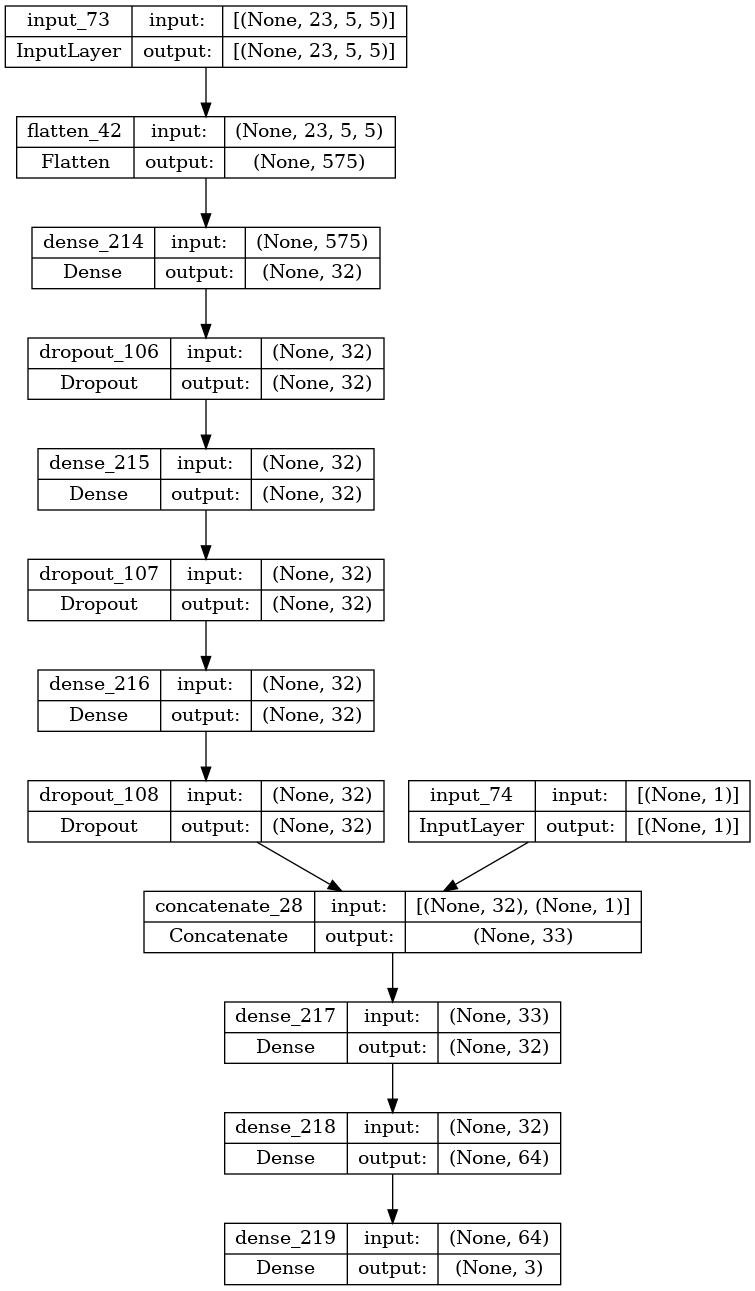

In [194]:
# the layers for the screen heatmap data
screen_input = Input(shape=screen_input_shape)
heatmap_layers = Flatten()(screen_input)
heatmap_layers = Dense(32, activation='relu')(heatmap_layers)
heatmap_layers = Dropout(0.25)(heatmap_layers)
heatmap_layers = Dense(32, activation='relu')(heatmap_layers)
heatmap_layers = Dropout(0.25)(heatmap_layers)
heatmap_layers = Dense(32, activation='sigmoid')(heatmap_layers)
heatmap_layers = Dropout(0.25)(heatmap_layers)

# concatenate flattened image branch with input features
elapsed_input = Input(shape=(elapsed_input_shape,))
concat = concatenate([heatmap_layers, elapsed_input])

# the layers for the elapsed time data
elapsed_layers = Dense(32, input_shape=(input_shape,), activation='relu')(concat)
elapsed_layers = Dense(64, activation='sigmoid')(elapsed_layers)

# define the output
output = Dense(elapsed_output_shape, activation='sigmoid')(elapsed_layers)

# create the model
model = Model(inputs=[screen_input, elapsed_input], outputs=output)

# plot the model architecture
#model.summary()
keras.utils.plot_model(model, show_shapes=True)

Epoch 1/40
36/36 [==============================] - 1s 7ms/step - loss: 0.6062 - accuracy: 0.5118 - val_loss: 0.5937 - val_accuracy: 0.5140
Epoch 2/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5946 - accuracy: 0.5131 - val_loss: 0.5914 - val_accuracy: 0.5140
Epoch 3/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5887 - accuracy: 0.5139 - val_loss: 0.5783 - val_accuracy: 0.5187
Epoch 4/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5716 - accuracy: 0.5454 - val_loss: 0.5600 - val_accuracy: 0.5543
Epoch 5/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5599 - accuracy: 0.5615 - val_loss: 0.5597 - val_accuracy: 0.5590
Epoch 6/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5555 - accuracy: 0.5644 - val_loss: 0.5535 - val_accuracy: 0.5649
Epoch 7/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5531 - accuracy: 0.5678 - val_loss: 0.5524 - val_accuracy: 0.5620
Epoch 8/40
36/36 [==

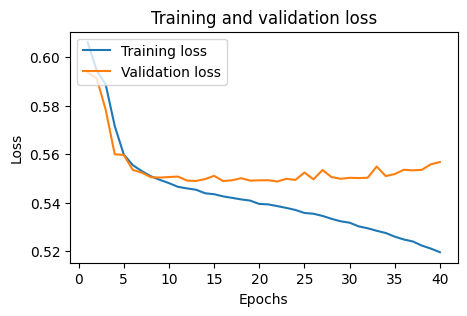

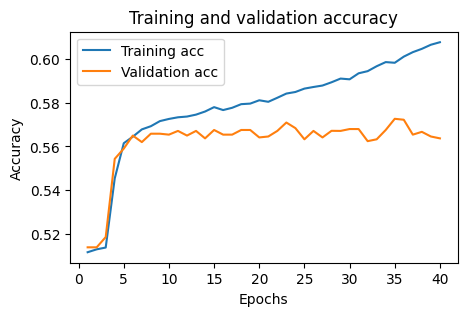

737/737 [==============================] - 0s 596us/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4350
           1       0.56      0.77      0.65     12090
           2       0.57      0.43      0.49      7120

   micro avg       0.56      0.53      0.54     23560
   macro avg       0.71      0.40      0.38     23560
weighted avg       0.65      0.53      0.48     23560
 samples avg       0.59      0.53      0.53     23560

Optimized threshold for best F1: 0.50


In [195]:
#class_weight = {0: 2, 1: 1.0}
class_weight = None

# compile the model
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

X_train = [
    good_student_features['train'][level_group],
    good_student_elapsed_time['train'][level_group]
]
y_train = good_student_target['train'][level_group]

X_val = [
    good_student_features['val'][level_group],
    good_student_elapsed_time['val'][level_group]
]
y_val = good_student_target['val'][level_group]

X_test = [
    good_student_features['test'][level_group],
    good_student_elapsed_time['test'][level_group]
]
y_test = good_student_target['test'][level_group]

_, _ = train_and_test_model(
    model=model,
    X_train = X_train,
    y_train=y_train,
    X_val = X_val,
    y_val=y_val,
    X_test = X_test,
    y_test=y_test,
    epochs=40,
    batch_size=2000,
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    class_weight=class_weight)

## Correct Prediction

In [50]:
def train_correct(model,
                  feature_dataset, 
                  target_dataset,
                  epochs=10,
                  batch_size=500,
                  optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  class_weight=None):
    _, _ = train_and_test_model(
        model=model,
        X_train=feature_dataset['train'],
        y_train=target_dataset['train'],
        X_val=feature_dataset['val'],
        y_val=target_dataset['val'],
        X_test=feature_dataset['test'],
        y_test=target_dataset['test'],
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)

### Get Datasets

In [51]:
# get the answers
answers_dataset = {}
for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
    answers_dataset[name] = create_answers_dataset(session_list, df_source_labels)


In [70]:
def get_feature_dataset(feature_list:list, include_question:bool=True) -> np.array:
    feature_dataset = {}
    for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
        feature_dataset[name] = create_answers_feature_dataset(session_list, df_source_labels, df_features, feature_list, include_question=include_question)

    return feature_dataset

In [53]:
answer_features_question_only = get_feature_dataset([])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [54]:
answer_features_question_only

{'train': array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int8),
 'val': array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int8),
 'test': array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int8)}

In [55]:
answer_features_elapsed_time = get_feature_dataset(['elapsed_time'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [71]:
answer_screen_heatmap_feature = get_feature_dataset(['screen_heatmap_feature'], include_question=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Question Number Only

In [57]:
# define the input shape
input_data = answer_features_question_only['train']
input_shape = (input_data.shape[1])
print('input_shape:', input_shape)

# define the output shape
output_data = answers_dataset['train']
output_shape = 1
print('output_shape', output_shape)

input_shape: 18
output_shape 1


In [58]:
model = Sequential()
model.add(Dense(32, input_shape=(input_shape,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(output_shape, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                608       
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
255/255 [==============================] - 1s 2ms/step - loss: 0.8712 - accuracy: 0.7033 - val_loss: 0.6326 - val_accuracy: 0.7268
Epoch 2/20
255/255 [==============================] - 0s 2ms/step - loss: 0.8342 - accuracy: 0.7264 - val_loss: 0.6023 - val_accuracy: 0.7268
Epoch 3/20
255/255 [==============================] - 0s 1ms/step - loss: 0.8036 - accuracy: 0.7245 - val_loss: 0.5838 - val_accuracy: 0.7140
Epoch 4/20
255/255 [==============================] - 0s 2ms/step - loss: 0.7840 - accuracy: 0.7136 - val_loss: 0.5760 - val_accuracy: 0.7140
Epoch 5/20
255/255 [==============================] - 0s 2ms/step - loss: 0.7752 - accuracy: 0.7121 - val_loss: 0.5763 - val_accuracy: 0.6983
Epoch 6/20
255/255 [==============================] - 0s 2ms/step - loss: 0.7720 - accuracy: 0.6980 - val_loss: 0.5749 - val_accuracy: 0.6983
Epoch 7/20
255/255 [==============================] - 0s 2ms/step - loss: 0.7709 - accuracy: 0.6980 - val_loss: 0.5704 - val_accuracy: 0.6983
Epoch 

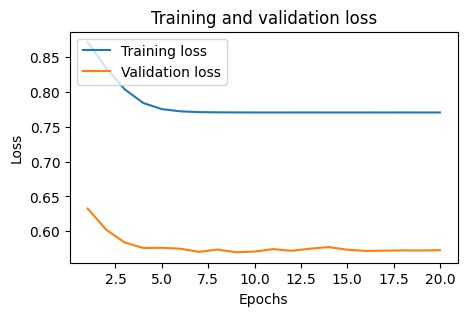

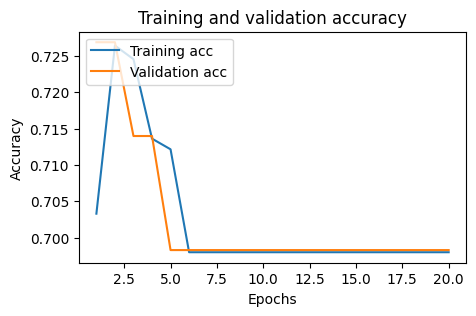

1326/1326 [==============================] - 1s 468us/step
              precision    recall  f1-score   support

           0       0.49      0.55      0.52     12572
           1       0.80      0.76      0.78     29836

    accuracy                           0.69     42408
   macro avg       0.64      0.65      0.65     42408
weighted avg       0.71      0.69      0.70     42408

Optimized threshold for best F1: 0.50


In [59]:
class_weight = {0: 2, 1: 1.0}

train_correct(
    model=model,
    feature_dataset=answer_features_question_only,
    target_dataset=answers_dataset,
    epochs=20,
    batch_size=500,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    class_weight=class_weight)

In [60]:
answer_array = []
for question in range(0, 19):
    # one hot encode the question
    question_one_hot = np.zeros(18)
    question_one_hot[question-1] = 1
    answer = model.predict([question_one_hot.tolist()], verbose=False)
    answer_array.append(int(answer > 0.5))
    print(f'Question {question} answer: {answer}')

print(answer_array)

Question 0 answer: [[0.9070698]]
Question 1 answer: [[0.5699438]]
Question 2 answer: [[0.96170396]]
Question 3 answer: [[0.87436306]]
Question 4 answer: [[0.6694347]]
Question 5 answer: [[0.37906867]]
Question 6 answer: [[0.6322136]]
Question 7 answer: [[0.57503444]]
Question 8 answer: [[0.44315833]]
Question 9 answer: [[0.57930297]]
Question 10 answer: [[0.3364648]]
Question 11 answer: [[0.46977848]]
Question 12 answer: [[0.7471675]]
Question 13 answer: [[0.15599696]]
Question 14 answer: [[0.55084306]]
Question 15 answer: [[0.31916168]]
Question 16 answer: [[0.5834583]]
Question 17 answer: [[0.52249944]]
Question 18 answer: [[0.9070698]]
[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]


### Elapsed Time

In [61]:
# define the input shape
input_data = answer_features_elapsed_time['train']
input_shape = (input_data.shape[1])
print('input_shape:', input_shape)

# define the output shape
output_data = answers_dataset['train']
output_shape = 1
print('output_shape', output_shape)

input_shape: 19
output_shape 1


In [62]:
model = Sequential()
model.add(Dense(64, input_shape=(input_shape,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Dense(output_shape, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                1280      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,665
Trainable params: 9,665
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
128/128 [==============================] - 0s 2ms/step - loss: 0.8774 - accuracy: 0.7114 - val_loss: 0.6296 - val_accuracy: 0.7191
Epoch 2/50
128/128 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.7149 - val_loss: 0.5930 - val_accuracy: 0.7117
Epoch 3/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7935 - accuracy: 0.6968 - val_loss: 0.5772 - val_accuracy: 0.6954
Epoch 4/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7767 - accuracy: 0.6882 - val_loss: 0.5681 - val_accuracy: 0.6951
Epoch 5/50
128/128 [==============================] - 0s 1ms/step - loss: 0.7720 - accuracy: 0.6882 - val_loss: 0.5728 - val_accuracy: 0.6880
Epoch 6/50
128/128 [==============================] - 0s 1ms/step - loss: 0.7706 - accuracy: 0.6874 - val_loss: 0.5681 - val_accuracy: 0.6903
Epoch 7/50
128/128 [==============================] - 0s 1ms/step - loss: 0.7695 - accuracy: 0.6876 - val_loss: 0.5655 - val_accuracy: 0.6914
Epoch 

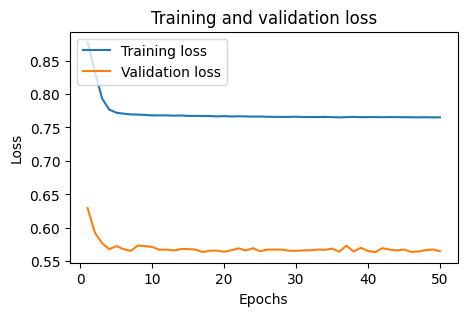

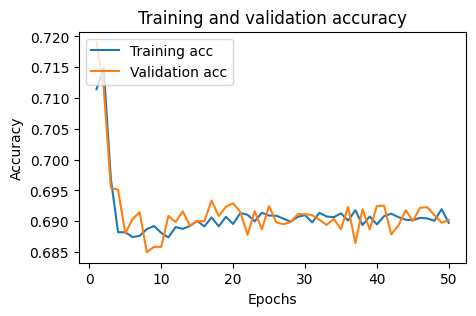

1326/1326 [==============================] - 1s 499us/step
              precision    recall  f1-score   support

           0       0.48      0.58      0.53     12572
           1       0.81      0.73      0.77     29836

    accuracy                           0.69     42408
   macro avg       0.64      0.66      0.65     42408
weighted avg       0.71      0.69      0.70     42408

Optimized threshold for best F1: 0.50


In [63]:
class_weight = {0: 2, 1: 1.0}

train_correct(
    model=model,
    feature_dataset=answer_features_elapsed_time,
    target_dataset=answers_dataset,
    epochs=50,
    batch_size=1000,
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    class_weight=class_weight)